<a href="https://colab.research.google.com/github/klsharma22/TensorflowCertifcationCourse/blob/main/10_time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with Milestone project

## Get data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-03-22 10:06:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.09s   

2024-03-22 10:06:54 (1.95 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-22 10:06:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-03-22 10:06:55 (8.25 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Importing data with pandas

In [3]:
# Import pandas
import pandas as pd
# Let's read the data and parse it
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates= ['Date'],
                 index_col= ['Date']) # parse date and telling pandas that column 1 is datetime

df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
# How many samples do we have
len(df)

2787

> **Note**: **Seasonality** pf a time series data is referd as the number of samples per year. For outr BitCoin prediction the seasonality is of daily so we will have 365 data per year

In [6]:
# Creating a new dataframe
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns= {'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Text(0.5, 1.0, 'Price of Bitcoin from 1 October 2013 to 18 May 2021')

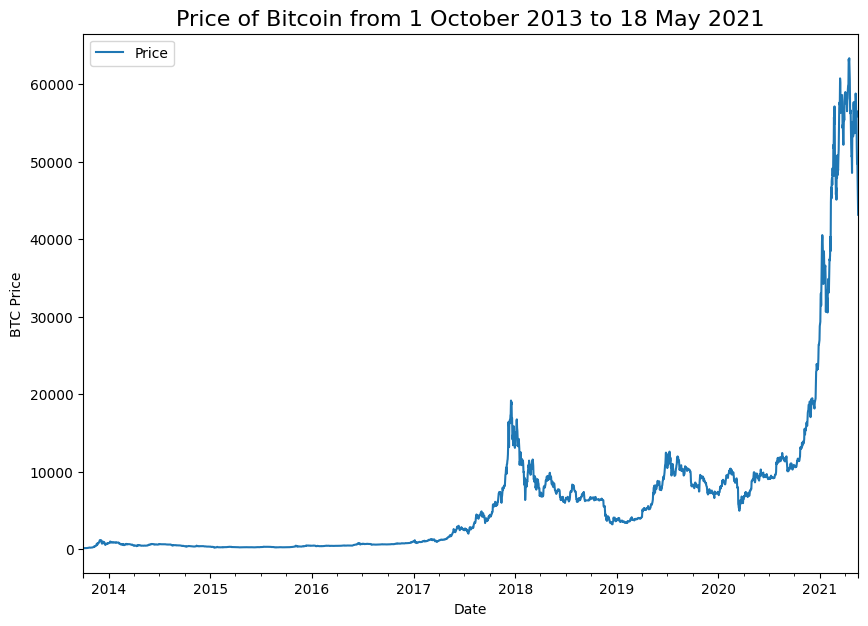

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize= (10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 October 2013 to 18 May 2021", fontsize= 16)

## Importing time series data using csv module

In [8]:
# Importing historical data with csv module
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 'r') as f:
  csv_reader = csv.reader(f, delimiter= ',')
  next(csv_reader) # This skips the header
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], '%Y-%m-%d')) # get the dates as dates and not string
    btc_price.append(float(line[2])) # get closing price

# View first 10 of each
timesteps[:10], btc_price[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 1.0, 'Price of Bitcoin from 1 October 2013 to 18 May 2021')

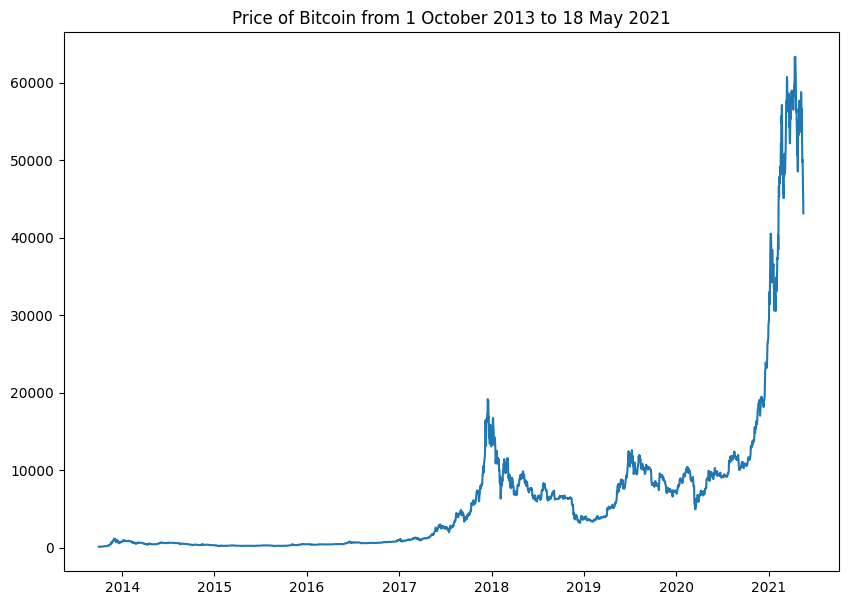

In [9]:
# Plot from the above data
plt.figure(figsize= (10, 7))
plt.plot(timesteps, btc_price)
plt.title('Price of Bitcoin from 1 October 2013 to 18 May 2021')

## Format data Part 1: Create train and test splits

### Creating train and test sets with time series data (the wrong way)

In [10]:
# Get the bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [11]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # BTC prices
                                                    test_size= 0.2,
                                                    random_state= 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

Text(0.5, 1.0, 'Data scatter plot')

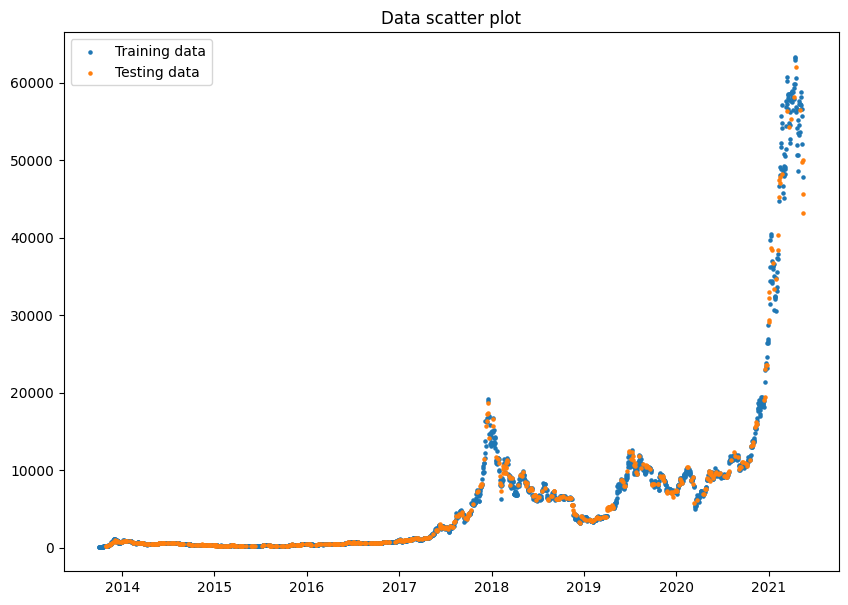

In [12]:
plt.figure(figsize= (10, 7))
plt.scatter(X_train, y_train, s = 5, label= 'Training data')
plt.scatter(X_test, y_test, s=5, label= 'Testing data')
plt.legend()
plt.title('Data scatter plot')

### Create train & test sets for time series (right way)

In [13]:
# Create train test set in the right way
split_size = int(0.8 * len(prices))

# Create train data splits
X_train, y_train = timesteps[: split_size], prices[:split_size]
# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

Text(0.5, 1.0, 'Data Plot in the right way')

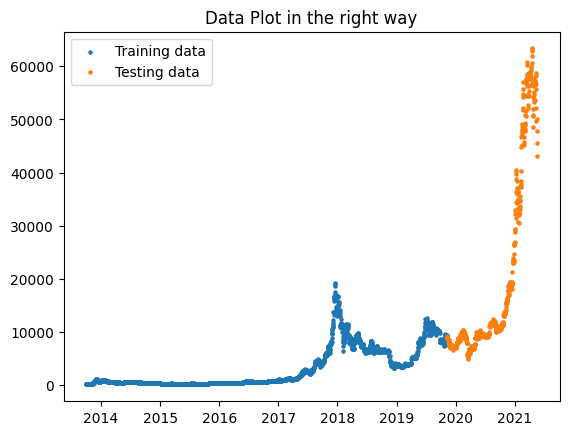

In [14]:
# Plot correctly made splits
plt.scatter(X_train, y_train, s=5, label= 'Training data')
plt.scatter(X_test, y_test, s=5, label= 'Testing data')
plt.legend()
plt.title('Data Plot in the right way')

## Create a plotting function

Typing plotting code is tedious, let's functionize it

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format= '.', start= 0, end= None, label= None):
  '''
  Plots timesteps againste a series of values

  Parameters:
    timesteps: An array of timesteps value where each record has been stored
    values: An array of the data that has been stored
    format: for the plotting
    start: from which index the user wants to view the plot
    end: to which index the user wants to view the plot
    label: label given to the plot
  '''
  # Plot time series data
  plt.plot(timesteps[start:end], values[start:end], format, label= label)
  plt.xlabel("Time")
  plt.ylabel('Price')

  if label:
    plt.legend(fontsize= 14)

  plt.grid(True)

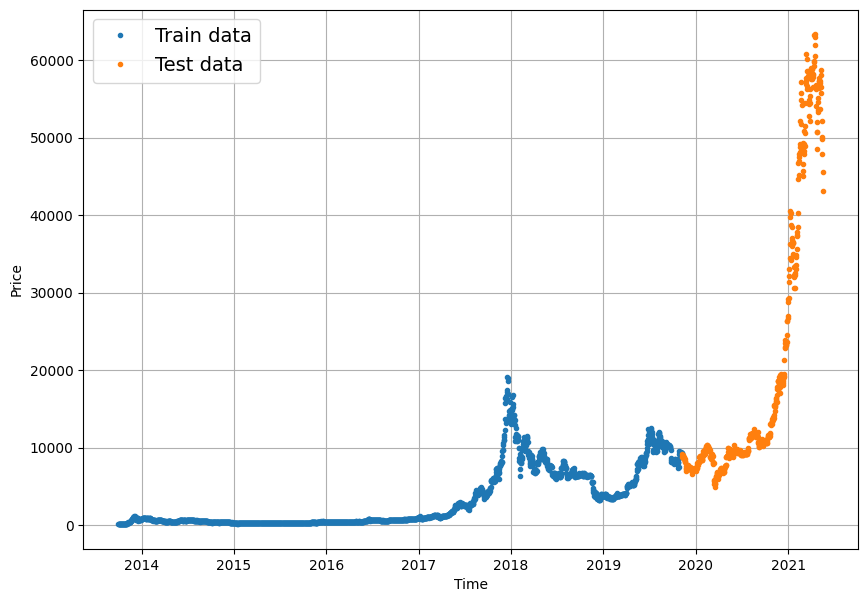

In [16]:
# Testing out funtion
plt.figure(figsize= (10, 7))
plot_time_series(X_train, y_train, label= 'Train data')
plot_time_series(X_test, y_test, label= 'Test data')

## Experiments

We've got our data ready for the modelling experiments. Let's perform the experiments as below:

Terms to be familiar with
* **Horizon**: number of timesteps we are going to predict in the future
* **Window size**: number of timesteps we are going to use to predict

0. Naive model (baseline)
1. Dense model window= 7, horizon= 1
2. Same model as 1 window= 30, horizon= 1
3. Same model as 1 window= 30, horizon= 7
4. Con1D
5. LSTM
6. Same as 1 (but as multivariate)
7. N-Beats Algorithm
8. Ensemble
9. Future prediction
10. Same as 1 but with turkey problem

### Model 0: Naive forecast

The formula of the Naive forecast is:

$$\hat{y}_{t} = y_{t-1}$$

In English:
> The prediction at timestep tis equal to the value at timestep t-1 (this is for horizon 1)


In [17]:
# Create naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

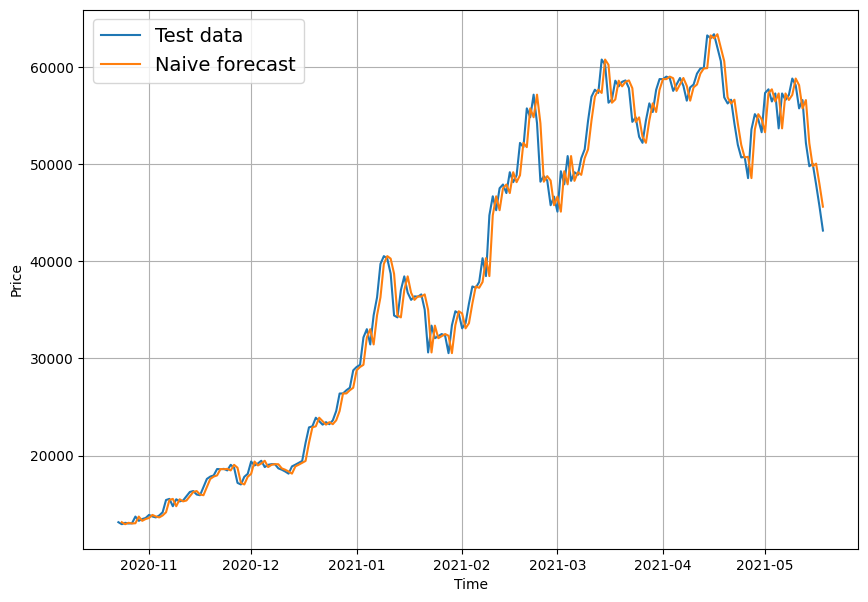

In [18]:
# Plot naive forecast
plt.figure(figsize= (10, 7))
# plot_time_series(timesteps= X_train, values= y_train, label= 'Train data')
plot_time_series(timesteps= X_test, values= y_test, start= 350, format= '-', label= 'Test data')
plot_time_series(timesteps= X_test[1:], values= naive_forecast, start= 350, format= '-', label= 'Naive forecast')


> **Exercise**: Spend 10 minutes reading [Forecasting methods](https://otexts.com/fpp3/simple-methods.html) and find out why is it difficult to beat naive forecasting

## Evauating a time series model

Let's look at some evaluation metrics for time series model

Since we're working in a regression problem, then we need to use the regression metrics:
* MAE
* MSE
* R2 Score
* RMSE
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all the abover metrics, the *lower the value the better*

The main thing is **how our model's forecasts comapre to against the actual value.**

In [19]:
import tensorflow as tf

In [20]:
# MASE implementation
def mase(y_true, y_pred):
  '''
  Implementing MASE (assuming that there is no seasonality of data)
  '''

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # out seasonality is one day hence the shift of one day

  return mae / mae_naive_no_season

In [21]:
mase(y_true= y_test[1:], y_pred= naive_forecast)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182624>

In [22]:
def evaluate_pred(y_true, y_pred):

  y_true= tf.cast(y_true, dtype= tf.float32)
  y_pred = tf.cast(y_pred, dtype= tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.math.sqrt(tf.keras.metrics.mean_squared_error(y_true, y_pred))
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  Mase = mase(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    Mase = tf.reduce_mean(Mase)

  return {
      'MAE': mae.numpy(),
      'MSE': mse.numpy(),
      'RMSE': rmse.numpy(),
      'MAPE': mape.numpy(),
      "MASE": Mase.numpy()
  }

In [23]:
naive_results = evaluate_pred(y_true= y_test[1:],
                              y_pred= naive_forecast)

naive_results

{'MAE': 567.9802,
 'MSE': 1147547.0,
 'RMSE': 1071.2362,
 'MAPE': 2.516525,
 'MASE': 0.99957}

## Other models you can use as baseline

There are many other models to use timeseries forecasting otehr than tensorflow

## Format Data Part 2: Windowing our dataset

We window our dataset so that we can covert our dataset into a supervised dataset

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [24]:
len(y_train)

2229

In [25]:
# What we want to do to our data
print(f"We want to use: {btc_price[:7]} to predict: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict: 123.033


In [26]:
# Let's setup a global variables for window and horizon size
HORIZON_SIZE = 1 # we need to predict next one day
WINDOW_SIZE = 7 # these are the past days we neet to look to predict

In [27]:
# Create function to label windowed data
def get_label_window(x, horizon= HORIZON_SIZE):
  '''
  Creates label for windowde dataset.

  Eg: if horizon = 1
  [0, 1, 2, 3, 4, 5, 6] -> [7]
  '''

  return x[:, :-horizon], x[:, -horizon:]

In [28]:
# Test out the window labelling function
test_window, test_label = get_label_window(tf.expand_dims(tf.range(8) + 1, axis= 0))
print(f"Wiindow: {test_window.numpy()} -> Label: {test_label.numpy()}")

Wiindow: [[1 2 3 4 5 6 7]] -> Label: [[8]]


In [29]:
tf.expand_dims(tf.range(8) + 1, axis= 0)

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7, 8]], dtype=int32)>

We've got a way to label our windowed data

However, this only owrks on a small circle

We need a way to do this to over entire data

We could do this using loops, however, for larger data it might take long time. Hence, to speed things up we will use Numpy array indexing.

Our function will:
1. Create a window step of specified window size
2. Use Numpy indexin to create a 2D array of multiple window steps, for eg:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps to inde on a target series
4. Uses our `get_label_window()` fuinction we created above to turn the window steps into windows witha specified horizon


In [30]:
import numpy as np
# Create function to view Numpy arrays as windows
def make_windows(x, window_size= WINDOW_SIZE, horizon= HORIZON_SIZE):
  '''
  Turns a 1D array into a 2D array of sequential labelled window_size with hroizon size labels
  '''

  # 1. Create a window of specific windo_size (add the horizon on the end of the labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis= 0)

  # 2. Create a 2D arrya of multiple window steps (minu 1 to account for 0 indexing)
  window_indices = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis= 0).T # create 2D array of windows of size window_size

  # print(f"Window indices: \n {window_indices, window_indices.shape}")

  # 3. Index on the target array with 2D array of multiple window steps
  window_array = x[window_indices]
  # print(window_array)

  # 4. Get the labelled windows
  windows, labels = get_label_window(window_array, horizon= horizon)

  return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices, window_size= WINDOW_SIZE, horizon= HORIZON_SIZE)
len(full_windows), len(full_labels)

(2780, 2780)

In [32]:
# View first 3 windows
for i in range(3):
  print(f"Windows: {full_windows[i]} -> Labels {full_labels[i]}")

Windows: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Labels [123.033]
Windows: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Labels [124.049]
Windows: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Labels [125.96116]


In [33]:
# View last 3 windows
for i in range(3):
  print(f"Windows: {full_windows[i - 3]} -> Labels: {full_labels[i - 3]}")

Windows: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Labels: [47885.62525472]
Windows: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Labels: [45604.61575361]
Windows: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Labels: [43144.47129086]


> **Note**: We can perform the above steps from the function refered in the below link: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [34]:
# Make train/test splits
def make_train_Test_splits(windows, labels, test_split= 0.2):
  '''
  Splits matching pairs of windows and labels into train and test splits
  '''

  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [35]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_Test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [36]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [37]:
test_windows[:5], test_windows[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
      

In [38]:
# Check to see if the train labels are the same
np.array_equal(np.squeeze(train_labels[:-HORIZON_SIZE - 1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoints

Because our model's performance will fluctuate from experiments to experiment, we're going to write a model checkpoit so we can compare with equal conditions.

More, specifically, we want to compare each of our model's best performancer against the other modle's best performance

In [39]:
SAVE_DIR= 'bitcoin_models'

In [40]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path= "model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(save_path, model_name),
                                            verbose= 0,
                                            monitor= 'val_loss',
                                            save_best_only= True)

### Model 1: Dense model (window= 7, horizon= 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLu
* An output layer with linear activation
* Adam optimization and MAE loss function
* Batch size of 128
* 100 epochs

In [41]:
from tensorflow.keras import layers

In [42]:
inputs = layers.Input(shape= (WINDOW_SIZE, ), name= 'input_layer')
x = layers.Dense(128, activation= 'relu', name= 'relu_layer_1')(inputs)
outputs = layers.Dense(HORIZON_SIZE, name= 'output')(x)

model_1 = tf.keras.Model(inputs, outputs, name= 'model_1_dense')

model_1.compile(loss= 'mae',
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['mae'])

model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 7)]               0         
                                                                 
 relu_layer_1 (Dense)        (None, 128)               1024      
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
history_model_1 = model_1.fit(train_windows,
                              train_labels,
                              epochs= 100,
                              verbose= 1,
                              batch_size= 128,
                              validation_data= (test_windows, test_labels),
                              callbacks= [create_model_checkpoint(model_name= model_1.name)])

Epoch 1/100
18/18 [==============================] - 2s 43ms/step - loss: 1595.7657 - mae: 1595.7657 - val_loss: 1444.6052 - val_mae: 1444.6052
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 341.3624 - mae: 341.3624 - val_loss: 1957.8970 - val_mae: 1957.8970
Epoch 3/100
18/18 [==============================] - 0s 28ms/step - loss: 221.6326 - mae: 221.6326 - val_loss: 1077.6533 - val_mae: 1077.6533
Epoch 4/100
18/18 [==============================] - 0s 25ms/step - loss: 180.5092 - mae: 180.5092 - val_loss: 1025.5751 - val_mae: 1025.5751
Epoch 5/100
18/18 [==============================] - 0s 26ms/step - loss: 173.0790 - mae: 173.0790 - val_loss: 953.4936 - val_mae: 953.4936
Epoch 6/100
18/18 [==============================] - 0s 27ms/step - loss: 168.9097 - mae: 168.9097 - val_loss: 953.1841 - val_mae: 953.1841
Epoch 7/100
18/18 [==============================] - 0s 27ms/step - loss: 166.0806 - mae: 166.0806 - val_loss: 918.1353 - val_mae: 918.1353
Epoch 8/100

In [44]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 574.3719 - mae: 574.3719


[574.3719482421875, 574.3719482421875]

In [45]:
# Load in saved best performing model_1 and evaluate it in test data
load_model_1 = tf.keras.models.load_model('model_experiments/model_1_dense/')
load_model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 566.7916 - mae: 566.7916


[566.7915649414062, 566.7915649414062]

## Making forecasts with a model(on the test dataset)

Let's write a function to:
1. Taking in a train model
2. Takes in some input data
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [46]:
def make_pred_and_evaluate(model, input_data, true_labels):
  model_pred = model.predict(input_data)
  return evaluate_pred(tf.squeeze(true_labels),
                       tf.squeeze(model_pred))

In [47]:
# model_1_pred = load_model_1.predict(test_windows)
model_1_pred = load_model_1.predict(test_windows)
model_1_results = make_pred_and_evaluate(load_model_1, test_windows, test_labels)
model_1_results

18/18 [==============================] - 0s 1ms/step


{'MAE': 566.79156,
 'MSE': 1167643.4,
 'RMSE': 1080.5754,
 'MAPE': 2.5371265,
 'MASE': 0.99569577}

In [48]:
naive_results

{'MAE': 567.9802,
 'MSE': 1147547.0,
 'RMSE': 1071.2362,
 'MAPE': 2.516525,
 'MASE': 0.99957}

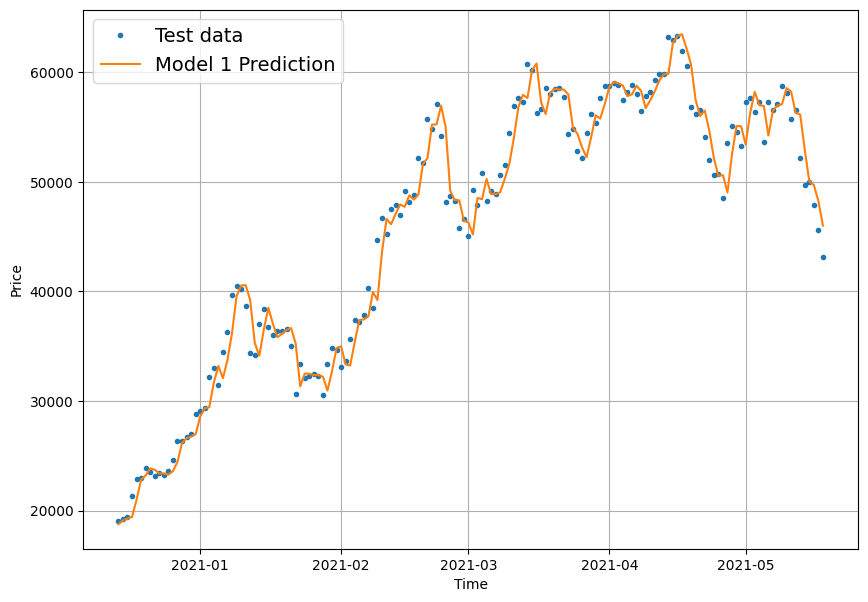

In [49]:
# Let's plot our model 1 predictions
offset = 400
plt.figure(figsize= (10, 7))
plot_time_series(timesteps= X_test[-len(test_windows):], values= test_labels[:, 0], start= offset, label= 'Test data')
plot_time_series(timesteps= X_test[-len(test_windows):], format='-', values= model_1_pred, start= offset, label= 'Model 1 Prediction')

### Model 2: Dense (window= 30, horizon= 1)

In [50]:
WINDOW_SIZE = 30

In [51]:
full_window_30, full_labels_30 = make_windows(prices,
                                              window_size= WINDOW_SIZE)

len(full_window_30), len(full_labels_30)

(2757, 2757)

In [52]:
train_windows, test_windows, train_labels, test_labels = make_train_Test_splits(full_window_30,
                                                                                full_labels_30,
                                                                                0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [53]:
inputs= layers.Input(shape= (WINDOW_SIZE, ), name= 'input_layer')
x = layers.Dense(128, activation= 'relu', name= 'dense_layer')(inputs)
outputs = layers.Dense(HORIZON_SIZE, name= 'output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs, name= 'model_2_dense_30')

model_2.compile(loss= 'mae',
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['mae'])

model_2.summary()

Model: "model_2_dense_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 30)]              0         
                                                                 
 dense_layer (Dense)         (None, 128)               3968      
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 4097 (16.00 KB)
Trainable params: 4097 (16.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
model_2.fit(train_windows,
            train_labels,
            epochs= 100,
            verbose= 1,
            batch_size= 128,
            validation_data= (test_windows, test_labels),
            callbacks= [create_model_checkpoint(model_name= model_2.name)])

Epoch 1/100
18/18 [==============================] - 1s 35ms/step - loss: 1768.5438 - mae: 1768.5438 - val_loss: 3504.6536 - val_mae: 3504.6536
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 550.6979 - mae: 550.6979 - val_loss: 2772.4885 - val_mae: 2772.4885
Epoch 3/100
18/18 [==============================] - 0s 27ms/step - loss: 333.9879 - mae: 333.9879 - val_loss: 1431.2549 - val_mae: 1431.2549
Epoch 4/100
18/18 [==============================] - 0s 26ms/step - loss: 259.0196 - mae: 259.0196 - val_loss: 1372.7812 - val_mae: 1372.7812
Epoch 5/100
18/18 [==============================] - 0s 24ms/step - loss: 230.5800 - mae: 230.5800 - val_loss: 1301.9642 - val_mae: 1301.9642
Epoch 6/100
18/18 [==============================] - 0s 25ms/step - loss: 207.2667 - mae: 207.2667 - val_loss: 1118.9102 - val_mae: 1118.9102
Epoch 7/100
18/18 [==============================] - 0s 25ms/step - loss: 183.4703 - mae: 183.4703 - val_loss: 1010.8057 - val_mae: 1010.8057
Epoc

In [55]:
# Evaluate model 2
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 824.7957 - mae: 824.7957


[824.7957153320312, 824.7957153320312]

In [56]:
load_model_2 = tf.keras.models.load_model('model_experiments/model_2_dense_30/')
load_model_2_pred = load_model_2.predict(test_windows)
model_2_results = make_pred_and_evaluate(load_model_2, test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step


In [57]:
model_2_results

{'MAE': 627.6437,
 'MSE': 1350633.5,
 'RMSE': 1162.1676,
 'MAPE': 2.828641,
 'MASE': 1.0971273}

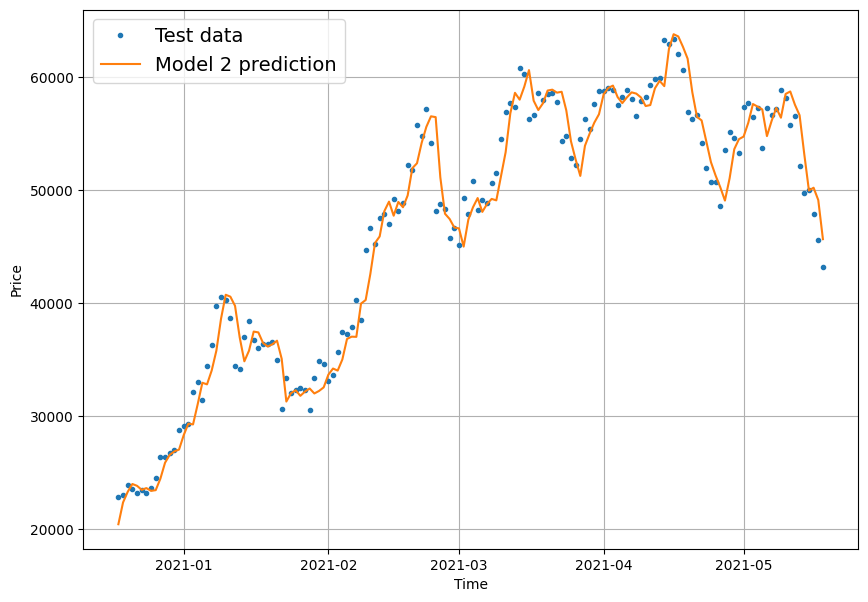

In [58]:
offset= 400
plt.figure(figsize= (10, 7))
plot_time_series(X_test[-len(test_windows):], values= test_labels[:, 0], start= offset, label= 'Test data')
plot_time_series(X_test[-len(test_windows):], values= load_model_2_pred, format= '-', start= offset, label= 'Model 2 prediction')

### Model 3: Dense (window size = 30, horizon size = 7)

In [59]:
WINDOW_SIZE= 30
HORIZON_SIZE= 7

In [60]:
# Creating the window and horizion dataset
full_30_windows, full_7_horizon = make_windows(prices,
                                               window_size= WINDOW_SIZE,
                                               horizon= HORIZON_SIZE)
len(full_30_windows), len(full_7_horizon)

(2751, 2751)

In [61]:
full_30_windows[:5], full_7_horizon[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [62]:
# Creating train and test split
train_windows, test_windows, train_labels, test_labels = make_train_Test_splits(full_30_windows,
                                                                                full_7_horizon,
                                                                                test_split= 0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [63]:
# Creating model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation= 'relu', name= 'dense_layer'),
    layers.Dense(HORIZON_SIZE, name= 'output_layer')
], name= 'model_3_30_7')

model_3.compile(loss= 'mae',
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['mae'])

model_3.build(input_shape= (None, WINDOW_SIZE))
model_3.summary()

Model: "model_3_30_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer (Dense)         (None, 128)               3968      
                                                                 
 output_layer (Dense)        (None, 7)                 903       
                                                                 
Total params: 4871 (19.03 KB)
Trainable params: 4871 (19.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
model_3.fit(train_windows,
            train_labels,
            epochs= 100,
            batch_size= 128,
            validation_data= (test_windows, test_labels),
            callbacks= [create_model_checkpoint(model_3.name)])

Epoch 1/100
18/18 [==============================] - 1s 33ms/step - loss: 1142.2178 - mae: 1142.2178 - val_loss: 3204.2285 - val_mae: 3204.2285
Epoch 2/100
18/18 [==============================] - 0s 25ms/step - loss: 555.9570 - mae: 555.9570 - val_loss: 2725.0593 - val_mae: 2725.0593
Epoch 3/100
18/18 [==============================] - 0s 24ms/step - loss: 470.1595 - mae: 470.1595 - val_loss: 2545.4758 - val_mae: 2545.4758
Epoch 4/100
18/18 [==============================] - 0s 24ms/step - loss: 428.0483 - mae: 428.0483 - val_loss: 2080.3918 - val_mae: 2080.3918
Epoch 5/100
18/18 [==============================] - 0s 28ms/step - loss: 393.0706 - mae: 393.0706 - val_loss: 2002.9031 - val_mae: 2002.9031
Epoch 6/100
18/18 [==============================] - 1s 30ms/step - loss: 361.2155 - mae: 361.2155 - val_loss: 1818.0747 - val_mae: 1818.0747
Epoch 7/100
18/18 [==============================] - 0s 27ms/step - loss: 339.0084 - mae: 339.0084 - val_loss: 1660.8790 - val_mae: 1660.8790
Epoc

In [65]:
# Evaluate model 3
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1250.3846 - mae: 1250.3846


[1250.3846435546875, 1250.3846435546875]

In [66]:
load_model_3 =tf.keras.models.load_model('/content/model_experiments/model_3_30_7/')
load_model_3_pred = load_model_3.predict(test_windows)
load_model_3_pred.shape, test_labels.shape

18/18 [==============================] - 0s 1ms/step


((551, 7), (551, 7))

In [67]:
len(load_model_3_pred.shape)

2

In [68]:
model_3_results = make_pred_and_evaluate(load_model_3, test_windows, test_labels)
model_3_results

18/18 [==============================] - 0s 1ms/step


{'MAE': 1231.2327,
 'MSE': 5396090.5,
 'RMSE': 1418.2589,
 'MAPE': 5.5232015,
 'MASE': 2.1909094}

We've made and evaluated predictions with `model_3`, let's visualize it

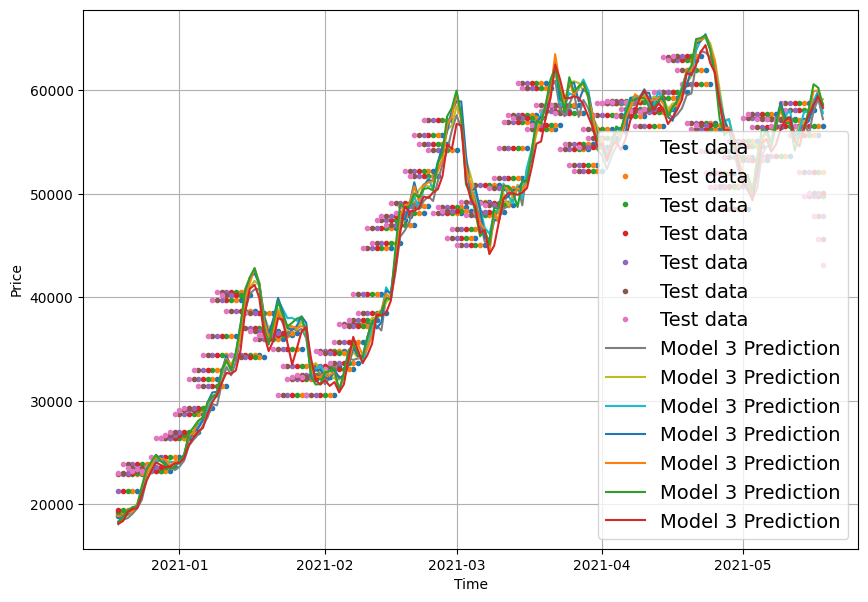

In [69]:
# Plot the predicted data and compare it with actual data
offset= 400
plt.figure(figsize= (10, 7))
plot_time_series(timesteps= X_test[-len(test_windows):],
                 values= test_labels,
                 start= offset,
                 label= 'Test data')
plot_time_series(timesteps= X_test[-len(test_windows):],
                 values= load_model_3_pred,
                 format= '-',
                 start= offset,
                 label= 'Model 3 Prediction')

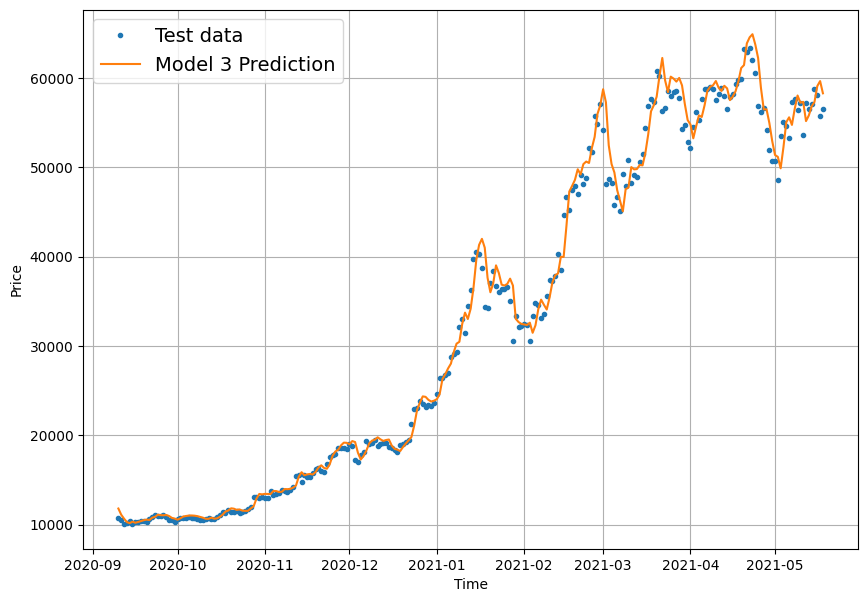

In [70]:
# Plot the predicted data and compare it with actual data
offset= 300
plt.figure(figsize= (10, 7))
plot_time_series(timesteps= X_test[-len(test_windows):],
                 values= test_labels[:, 0],
                 start= offset,
                 label= 'Test data')
plot_time_series(timesteps= X_test[-len(test_windows):],
                 values= tf.reduce_mean(load_model_3_pred, axis= 1),
                 format= '-',
                 start= offset,
                 label= 'Model 3 Prediction')

## Comparing models uptil now

In [71]:
model_results = pd.DataFrame({
    'baseline_model': naive_results,
    'model_1': model_1_results,
    'model_2': model_2_results,
    'model_3': model_3_results
})

model_results = model_results.transpose()

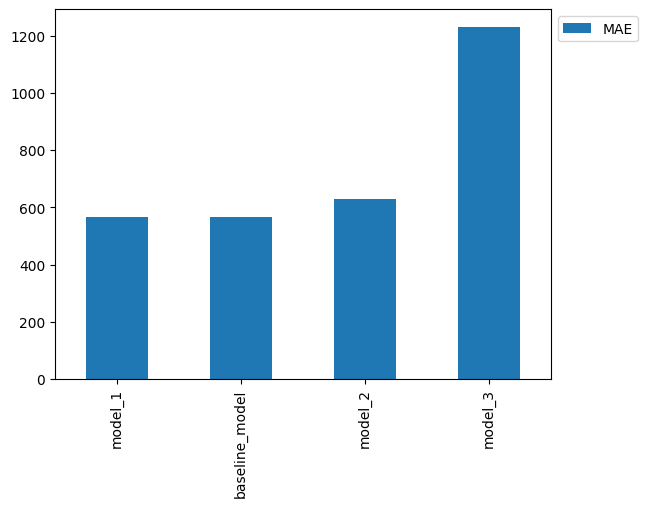

In [72]:
model_results['MAE'].sort_values(ascending= True).plot.bar().legend(bbox_to_anchor= (1.0, 1.0))

### Model 4: CNN 1D



In [73]:
HORIZON_SIZE = 1
WINDOW_SIZE = 7

In [74]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size= WINDOW_SIZE, horizon= HORIZON_SIZE)
len(full_windows), len(full_labels)

(2780, 2780)

In [75]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_Test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

We need an input shape of: `(batch_size, timesteps, input_dim)`

In [76]:
# Check data input shape
train_windows[0].shape

(7,)

In [77]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [78]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis= 0)) # add an extra dimension

In [79]:
# Test out our lambda layer
print(f"Original values: {x}")
print(f"Original shape: {x.shape}") # (WINDOW_SIZE, )
print(f"Expande shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape: {expand_dims_layer(x)}")

Original values: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
Original shape: (7,)
Expande shape: (1, 7)
Original values with expanded shape: [[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]]


In [80]:
x.numpy()

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])

In [81]:
# Create Conv1D

# lambda layer
# Conv1D model, filter= 128, kernel_size=, padding....
# output layer = dense

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis= 1), name= 'expand_dims_layer'),
    layers.Conv1D(128, 5, activation= 'relu', padding= 'causal', name= 'cnn_1d_layer'),
    layers.Dense(HORIZON_SIZE, activation= 'relu', name= 'output_layer')
], name= 'model_4_cnn_1d')

model_4.compile(loss= 'mae',
                optimizer= tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            epochs= 100,
            batch_size= 128,
            validation_data= (test_windows, test_labels),
            callbacks= [create_model_checkpoint(model_4.name)])

Epoch 1/100
18/18 [==============================] - 3s 46ms/step - loss: 3158.3894 - val_loss: 20096.3672
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 3158.3889 - val_loss: 20096.3672
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 3158.3899 - val_loss: 20096.3672
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 3158.3892 - val_loss: 20096.3672
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 3158.3894 - val_loss: 20096.3672
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 3158.3894 - val_loss: 20096.3672
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 3158.3892 - val_loss: 20096.3672
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 3158.3892 - val_loss: 20096.3672
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 3158.3894 - val_loss: 20096.3672
Epoch 10/100
18/18 [=========================

In [82]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 20096.3672


20096.3671875

In [83]:
load_model_4 = tf.keras.models.load_model('/content/model_experiments/model_4_cnn_1d/')
load_model_4_pred = load_model_4.predict(test_windows)
model_4_results = make_pred_and_evaluate(load_model_4, test_windows, test_labels)
model_4_results

18/18 [==============================] - 0s 2ms/step


{'MAE': 20096.37,
 'MSE': 711060700.0,
 'RMSE': 26665.72,
 'MAPE': 100.0,
 'MASE': 35.303753}

In [84]:
model_results = model_results.transpose()
model_results

,baseline_model,model_1,model_2,model_3
MAE,5.679802e+02,5.667916e+02,6.276437e+02,1.231233e+03
MSE,1.147547e+06,1.167643e+06,1.350634e+06,5.396090e+06
RMSE,1.071236e+03,1.080575e+03,1.162168e+03,1.418259e+03
MAPE,2.516525e+00,2.537127e+00,2.828641e+00,5.523201e+00
MASE,9.995700e-01,9.956958e-01,1.097127e+00,2.190909e+00


In [85]:
model_results['model_4'] = model_4_results

In [86]:
model_results = model_results.transpose()
model_results

,MAE,MSE,RMSE,MAPE,MASE
baseline_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1,566.791565,1.167643e+06,1080.575439,2.537127,0.995696
model_2,627.643677,1.350634e+06,1162.167603,2.828641,1.097127
model_3,1231.232666,5.396090e+06,1418.258911,5.523201,2.190909
model_4,20096.369141,7.110607e+08,26665.720703,100.000000,35.303753


### Model 5: RNN (LSTM)

In [87]:
# Create model with Functional API
inputs = layers.Input(shape= (WINDOW_SIZE), name= 'input_layer')
x = layers.Lambda(lambda x: tf.expand_dims(x, axis= 1), name= 'expand_dims_layer')(inputs)
x = layers.LSTM(128, activation= 'relu', return_sequences= True, name= 'LSTM_layer_1')(x)
x = layers.LSTM(128, activation= 'relu', name= 'LSTM_layer_2')(x)
x = layers.Dense(32, activation= 'relu')(x)
outputs = layers.Dense(HORIZON_SIZE, name= 'output_layer')(x)

model_5 = tf.keras.Model(inputs, outputs, name= 'model_5_LSTM')

model_5.compile(loss= 'mae',
                optimizer= tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs= 100,
            verbose= 1,
            validation_data= (test_windows, test_labels),
            callbacks= [create_model_checkpoint(model_5.name)])

Epoch 1/100
70/70 [==============================] - 7s 48ms/step - loss: 1489.6484 - val_loss: 1057.4897
Epoch 2/100
70/70 [==============================] - 3s 43ms/step - loss: 190.4465 - val_loss: 1028.6025
Epoch 3/100
70/70 [==============================] - 3s 46ms/step - loss: 190.2570 - val_loss: 1006.5796
Epoch 4/100
70/70 [==============================] - 3s 42ms/step - loss: 168.9379 - val_loss: 860.0113
Epoch 5/100
70/70 [==============================] - 3s 43ms/step - loss: 156.6256 - val_loss: 827.2366
Epoch 6/100
70/70 [==============================] - 3s 49ms/step - loss: 157.5377 - val_loss: 815.6776
Epoch 7/100
70/70 [==============================] - 0s 7ms/step - loss: 159.5627 - val_loss: 857.8333
Epoch 8/100
70/70 [==============================] - 0s 7ms/step - loss: 144.5521 - val_loss: 818.4759
Epoch 9/100
70/70 [==============================] - 3s 42ms/step - loss: 134.2942 - val_loss: 687.5124
Epoch 10/100
70/70 [==============================] - 1s 7ms/s

In [88]:
# Evaluate model
load_model_5 = tf.keras.models.load_model('/content/model_experiments/model_5_LSTM/')
load_model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 565.2007


565.2007446289062

In [89]:
model_5_pred = load_model_5.predict(test_windows)
model_5_pred[:5]

18/18 [==============================] - 0s 2ms/step


array([[8813.518],
       [8756.39 ],
       [9010.664],
       [8740.191],
       [8726.268]], dtype=float32)

In [90]:
model_5_results = make_pred_and_evaluate(load_model_5, test_windows, test_labels)
model_5_results

18/18 [==============================] - 0s 2ms/step


{'MAE': 565.2008,
 'MSE': 1157290.4,
 'RMSE': 1075.7743,
 'MAPE': 2.5440896,
 'MASE': 0.99290127}

In [91]:
model_results = model_results.transpose()

In [92]:
model_results['model_5'] = model_5_results
model_results = model_results.transpose()
model_results

,MAE,MSE,RMSE,MAPE,MASE
baseline_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1,566.791565,1.167643e+06,1080.575439,2.537127,0.995696
model_2,627.643677,1.350634e+06,1162.167603,2.828641,1.097127
model_3,1231.232666,5.396090e+06,1418.258911,5.523201,2.190909
model_4,20096.369141,7.110607e+08,26665.720703,100.000000,35.303753
model_5,565.200806,1.157290e+06,1075.774292,2.544090,0.992901


## Make a multivariate time series dataset

Befoer we add a feature to our time series, what is a feature we can use?

Block reward halving events

In [93]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [94]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - not in our timestamp
block_reward_2 = 25 # 8th November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block Reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64('2020-05-18')

In [95]:
# Create date ranges of where specific block_reward values
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

In [96]:
# Add data in the dataframe
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days: block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days: , -1] = block_reward_4

bitcoin_prices_block

,Price,block_reward
Date,,
2013-10-01,123.654990,25
2013-10-02,125.455000,25
2013-10-03,108.584830,25
2013-10-04,118.674660,25
2013-10-05,121.338660,25
...,...,...
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25


<Axes: xlabel='Date'>

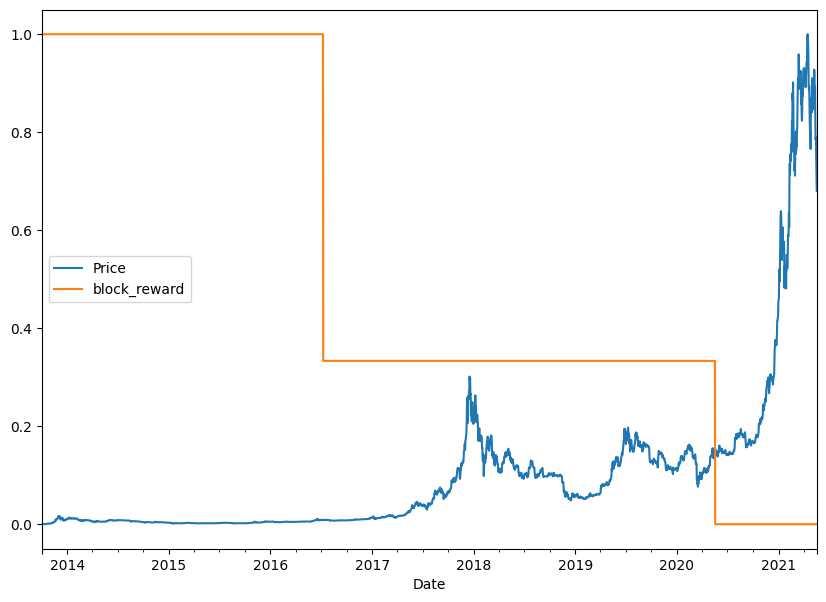

In [97]:
# Plot the block reward vs prce over time
from sklearn.preprocessing import minmax_scale
scaled_prices_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                      columns= bitcoin_prices_block.columns,
                                      index = bitcoin_prices_block.index)
scaled_prices_block_df.plot(figsize= (10, 7))

## Making a windowed dataset with pandas

Previously, we turned our univariate time series into winodwoed dataset using helper function.

However, that wont work on multivariate data

So, we will use pandas shift method

In [98]:
# Setup dataset hyperparameters
WINDOW_SIZE, HORIZON_SIZE

(7, 1)

In [99]:
# Make a copy of the Bitcoin historical data
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods= i + 1)

bitcoin_prices_windowed

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.654990,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455000,25,123.654990,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584830,25,125.455000,123.654990,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,25,108.584830,125.455000,123.654990,NaN,NaN,NaN,NaN
2013-10-05,121.338660,25,118.674660,108.584830,125.455000,123.654990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679


We've created window dataset from the fshift function of the pandas and make it till it contains all features required for the model

In [100]:
# Create X and y features
X = bitcoin_prices_windowed.dropna().drop('Price', axis= 1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

X.head(), y.head()

(            block_reward     Price+1     Price+2     Price+3     Price+4  \
 Date                                                                       
 2013-10-08          25.0  121.794998  120.655327  121.338661  118.674660   
 2013-10-09          25.0  123.032997  121.794998  120.655327  121.338661   
 2013-10-10          25.0  124.049004  123.032997  121.794998  120.655327   
 2013-10-11          25.0  125.961159  124.049004  123.032997  121.794998   
 2013-10-12          25.0  125.279663  125.961159  124.049004  123.032997   
 
                Price+5     Price+6     Price+7  
 Date                                            
 2013-10-08  108.584831  125.455002  123.654991  
 2013-10-09  118.674660  108.584831  125.455002  
 2013-10-10  121.338661  118.674660  108.584831  
 2013-10-11  120.655327  121.338661  118.674660  
 2013-10-12  121.794998  120.655327  121.338661  ,
 Date
 2013-10-08    123.032997
 2013-10-09    124.049004
 2013-10-10    125.961159
 2013-10-11    125.27966

In [101]:
# Make train and test sets
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [102]:
X_train.shape

(2224, 8)

In [103]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 7)]               0         
                                                                 
 relu_layer_1 (Dense)        (None, 128)               1024      
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [104]:
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation= 'relu', name= 'relu_layer_1'),
    layers.Dense(HORIZON_SIZE)
], name='model_6_Multivairate')

model_6.compile(loss= 'mae',
                optimizer= tf.keras.optimizers.Adam())

model_6.fit(X_train,
            y_train,
            epochs= 100,
            validation_data= (X_test, y_test),
            verbose= 1,
            callbacks= [create_model_checkpoint(model_6.name)])

Epoch 1/100
70/70 [==============================] - 1s 9ms/step - loss: 825.4960 - val_loss: 1436.0254
Epoch 2/100
70/70 [==============================] - 0s 7ms/step - loss: 201.0620 - val_loss: 1143.7532
Epoch 3/100
70/70 [==============================] - 0s 7ms/step - loss: 168.7835 - val_loss: 912.7094
Epoch 4/100
70/70 [==============================] - 0s 7ms/step - loss: 155.4427 - val_loss: 807.9600
Epoch 5/100
70/70 [==============================] - 1s 7ms/step - loss: 150.3185 - val_loss: 763.7437
Epoch 6/100
70/70 [==============================] - 1s 7ms/step - loss: 139.7007 - val_loss: 729.3853
Epoch 7/100
70/70 [==============================] - 1s 14ms/step - loss: 132.9852 - val_loss: 701.2972
Epoch 8/100
70/70 [==============================] - 1s 8ms/step - loss: 131.0786 - val_loss: 683.0246
Epoch 9/100
70/70 [==============================] - 0s 3ms/step - loss: 131.9972 - val_loss: 703.9271
Epoch 10/100
70/70 [==============================] - 0s 3ms/step - lo

In [105]:
load_model_6 = tf.keras.models.load_model('/content/model_experiments/model_6_Multivairate/')
load_model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 565.1685


565.1685180664062

In [106]:
model_6_results = make_pred_and_evaluate(load_model_6, X_test, y_test)
model_6_results

18/18 [==============================] - 0s 1ms/step


{'MAE': 565.16846,
 'MSE': 1158221.0,
 'RMSE': 1076.2068,
 'MAPE': 2.5247126,
 'MASE': 0.99284446}

In [107]:
model_1_results

{'MAE': 566.79156,
 'MSE': 1167643.4,
 'RMSE': 1080.5754,
 'MAPE': 2.5371265,
 'MASE': 0.99569577}

In [108]:
model_results.dropna(inplace= True)

In [109]:
model_results = model_results.transpose()
model_results['model_6'] = model_6_results
model_results = model_results.transpose()
model_results

,MAE,MSE,RMSE,MAPE,MASE
baseline_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1,566.791565,1.167643e+06,1080.575439,2.537127,0.995696
model_2,627.643677,1.350634e+06,1162.167603,2.828641,1.097127
model_3,1231.232666,5.396090e+06,1418.258911,5.523201,2.190909
model_4,20096.369141,7.110607e+08,26665.720703,100.000000,35.303753
model_5,565.200806,1.157290e+06,1075.774292,2.544090,0.992901
model_6,565.168457,1.158221e+06,1076.206787,2.524713,0.992844


### Model 7: N-BEATS Algorithm

We are going to replicate the model from the N-BEATS algorithm paper

Why?
* This will allow us to practice replicating a paer with TensorFlow code
* We will see how to use TensorFlow layer subclassing
* Get experience using Functional API to create a custom architecture
* Potentially get the state of the art performance on our dataset

#### Building and testing the N-BEATS block layer

> **Reference**: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing

In [110]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs # these are for the other defualt keywords of the classes
               ):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 FC layers each has relu connections
    self.hidden = [tf.keras.layers.Dense(self.n_neurons, activation= 'relu') for _ in range(self.n_layers)]

    #Output of the block is a theta layer from a linear layer
    self.theta_layer = tf.keras.layers.Dense(self.theta_size, activation= 'linear', name= 'theta')


  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)

    theta = self.theta_layer(x)

    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon]

    return backcast, forecast

Let's test our NBeatsBlock class

In [111]:
# Set up dummy NBeatBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size= WINDOW_SIZE,
                                       theta_size= WINDOW_SIZE + HORIZON_SIZE,
                                       horizon= HORIZON_SIZE,
                                       n_neurons= 128,
                                       n_layers= 4)

In [112]:
# Create dummy inputs (have to be same as the input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis= 0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [113]:
# Pass dummy inputs to dummy NBeats Block layer instance
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# They'll be random due to no training
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.03476802  0.3122864  -0.11555219  0.20107043  0.1111746  -0.82724875
 -0.1603622 ]
Forecast: -0.7159718871116638


## Preparing data for the N-BEATS algorthm using `tf.data`

To make our input data as fast as possible we're going to be connecting the performance data pipeline steps in the tf.data

In [114]:
HORIZON_SIZE = 1
WINDOWS_SIZE = 7

In [115]:
# Create NBEATS data inputs (univariate)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [116]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f'Price+{i + 1}'] = bitcoin_prices_nbeats['Price'].shift(periods= i + 1)

bitcoin_prices_nbeats.iloc[:10, :]

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [117]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop('Price', axis= 1)
y = bitcoin_prices_nbeats.dropna()['Price']

# Make train and test sets
split_size= int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [118]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset)).batch(1024).prefetch(tf.data.AUTOTUNE)
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset)).batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair feew number of parameters

In [119]:
# Vlaues from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON_SIZE
THETA_SIZE = INPUT_SIZE + HORIZON_SIZE

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for resisual connections

The NBEATS algorithm uses doubly residual stacking to help train its deep architecure

In [120]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Addition
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the NBEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock`
2. Create an input layer for the N-BEATS stack using the Keras Functional API
3. Make the initial backcast and forecast for the model with the layer created
4. Use loop to create stacks of block layers
5. Use the `NBeatBlock` class within the for loop to create blocks which returns backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss and Adam optimizer with default settings
9. Fit the N-BEATS model for 5000 epochs and since it's foitting for so many epochs, we'll use:
  * Early Stoping callbcak
  * ReduceLRonPlateau callback

In [121]:
%%time

tf.random.set_seed(42)

# 1. Setup the instance of NbeatsBloc
nbeats_block_layer= NBeatsBlock(INPUT_SIZE,
                                THETA_SIZE,
                                HORIZON_SIZE,
                                N_NEURONS,
                                N_LAYERS,
                                name= 'Init_Block')

# 2. Create an input layer
stack_inputs = layers.Input(shape= (INPUT_SIZE, ), name= 'stack_input')

# 3. Create initial backcast and forecast input
residuals, forecast = nbeats_block_layer(stack_inputs)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS - 1)):

  # 5. Use the NBeatBlock to claculate the backcaste and the forecaste
  backcast, block_forecast = NBeatsBlock(INPUT_SIZE,
                                   THETA_SIZE,
                                   HORIZON_SIZE,
                                   N_NEURONS,
                                   N_LAYERS,
                                   name= f'NBeatsBlock_{i}'
                                   )(residuals)
  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name= f'subtract_{i}')
  forecast = layers.add([forecast, block_forecast], name= f'add_{i}')

# 7. Put together the inputs and outputs
model_7 = tf.keras.Model(inputs= stack_inputs, outputs= forecast, name= 'model_7_NBEATS')

# 8. Compile the model with MAE loss
model_7.compile(loss= 'mae',
                optimizer= tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                  patience= 200,
                                                  restore_best_weights= True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss',
                                                 patience= 100,
                                                 verbose= 1)

model_7.fit(train_dataset,
            epochs= N_EPOCHS,
            validation_data= test_dataset,
            verbose= 0,
            callbacks= [early_stopping, reduce_lr])



Epoch 709: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1170: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1270: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 4min 53s, sys: 9.92 s, total: 5min 3s
Wall time: 5min 5s


In [122]:
# Evaluate the model
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 22ms/step - loss: 573.7764


573.7764282226562

In [123]:
# Make predictions with N-BEATS model
model_7_pred = model_7.predict(test_dataset)
model_7_results = evaluate_pred(y_test,
                                model_7_pred)
model_7_results

1/1 [==============================] - 1s 1s/step


{'MAE': 573.7764,
 'MSE': 1173465.5,
 'RMSE': 1083.2661,
 'MAPE': 2.6105344,
 'MASE': 1.0079663}

In [124]:
naive_results

{'MAE': 567.9802,
 'MSE': 1147547.0,
 'RMSE': 1071.2362,
 'MAPE': 2.516525,
 'MASE': 0.99957}

### Plot the N-BEATS architecutere we've created

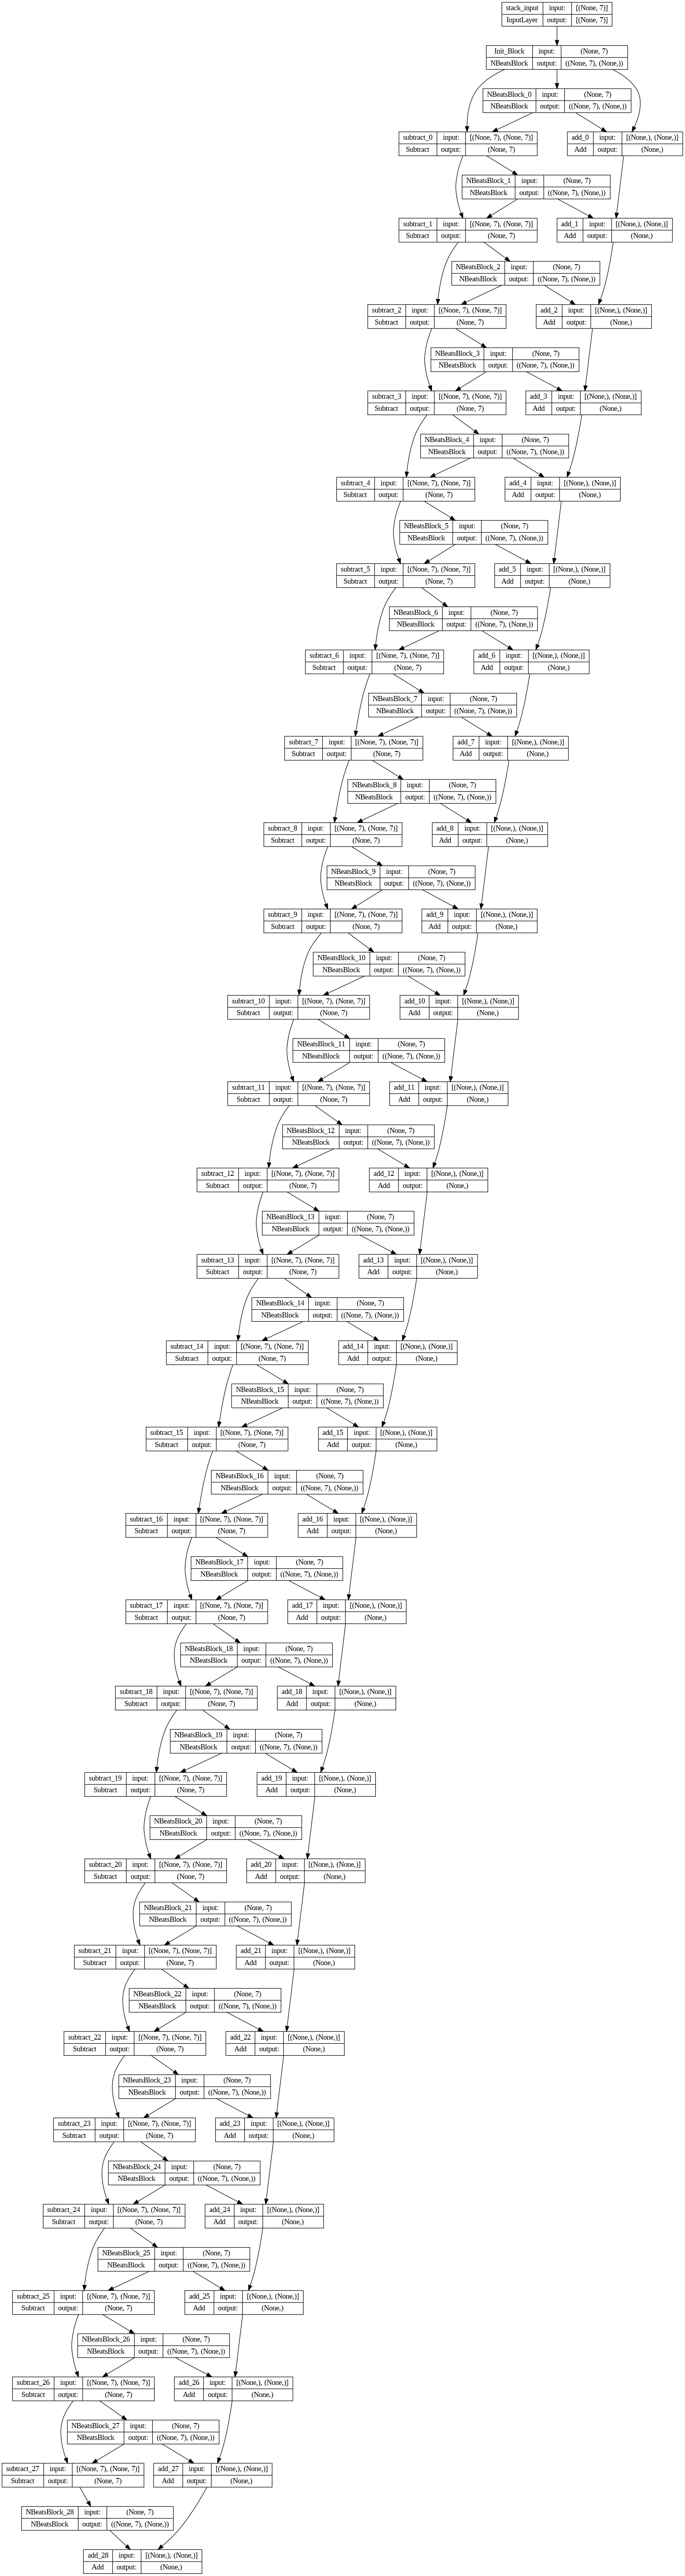

In [125]:
from tensorflow.keras.utils import plot_model
plot_model(model_7, show_shapes= True)

### Model 8: Creating Ensemble

An ensemble leaverages the wishone of crowd effect

it combines many *different* models to predict a common goal

In [126]:
HORIZON_SIZE, WINDOW_SIZE

(1, 7)

#### Constructing and fitting and ensembbles of models (using different loss functions)

In [127]:
def get_ensemble_model(horizon= HORIZON_SIZE,
                       train_data= train_dataset,
                       test_data= test_dataset,
                       num_iter= 10,
                       num_epochs= 1000,
                       loss_funcs = ['mae', 'mse', 'mape']):
  '''
  returns a list of num_iter models each trained on MAE, MSE ad MAPE loss.
  '''

  ensemble_models = []

  # Created num_term number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_func in loss_funcs:
      print(f"Optimising model by reducing: {loss_func} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model 1)
      model = tf.keras.Sequential([
          # Initialise dense layer with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer= 'he_normal', activation= 'relu'),
          layers.Dense(128, kernel_initializer= 'he_normal', activation= 'relu'),
          layers.Dense(HORIZON_SIZE)
      ], name= f'model_{i}_ensemble')

      # Compile simple model with current loss function
      model.compile(loss= loss_func,
                    optimizer= tf.keras.optimizers.Adam(),
                    metrics= ['mae', 'mse'])

      # Fit the current model
      model.fit(train_data,
                epochs= num_epochs,
                verbose= 0,
                validation_data= test_data,
                callbacks= [tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                             patience= 200,
                                                             restore_best_weights= True),
                            tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss',
                                                                 patience= 100,
                                                                 verbose= 1)])

      # Append fitted model
      ensemble_models.append(model)

  return ensemble_models

In [128]:
%%time
# Get list of ensemble models
ensemble_models= get_ensemble_model(num_iter= 5,
                                    num_epochs= 1000)

Optimising model by reducing: mae for 1000 epochs, model number: 0

Epoch 441: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimising model by reducing: mse for 1000 epochs, model number: 0

Epoch 568: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 668: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimising model by reducing: mape for 1000 epochs, model number: 0

Epoch 270: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 370: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimising model by reducing: mae for 1000 epochs, model number: 1
Optimising model by reducing: mse for 1000 epochs, model number: 1

Epoch 262: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 362: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimising model by reducing: mape for 1000 epochs, model number: 1

Epoch 181: ReduceLROnPlateau reduci

In [129]:
len(ensemble_models)

15

In [130]:
ensemble_models

In [131]:
def make_preds(model, input_data):
  return model.predict(input_data)

In [132]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)

  return tf.constant(tf.squeeze(ensemble_preds))

In [133]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)

ensemble_preds

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 39ms/step
CPU times: user 714 ms, sys: 43.9 ms, total: 758 ms
Wall time: 715 ms


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8902.318,  8770.583,  9080.756, ..., 49957.098, 48571.402,
        46089.59 ],
       [ 8753.495,  8730.131,  8999.535, ..., 50344.035, 48532.082,
        46240.047],
       [ 8781.174,  8771.119,  9079.371, ..., 49759.195, 48725.13 ,
        45772.61 ],
       ...,
       [ 8788.85 ,  8825.684,  9093.701, ..., 50183.547, 48322.27 ,
        46075.918],
       [ 8796.444,  8752.762,  9093.239, ..., 50398.742, 48599.043,
        46030.582],
       [ 8804.385,  8761.726,  9053.576, ..., 49550.65 , 47746.457,
        45808.83 ]], dtype=float32)>

Our ensemble preds come out in multiple dimensions but to combine into **point predictions** we can leverage the mean or median of all the predictions of the median

In [134]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_pred(y_test, ensemble_preds)
ensemble_results

{'MAE': 580.2535,
 'MSE': 1183627.6,
 'RMSE': 1087.9122,
 'MAPE': 2.6333468,
 'MASE': 1.0193446}

In [135]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis= 0)
ensemble_mean_results = evaluate_pred(y_test, ensemble_mean)
ensemble_mean_results

{'MAE': 570.5577,
 'MSE': 1151928.1,
 'RMSE': 1073.2792,
 'MAPE': 2.5677178,
 'MASE': 1.0023118}

In [136]:
ensemble_median = np.median(ensemble_preds, axis= 0)
ensemble_median_results = evaluate_pred(y_test, ensemble_median)
ensemble_median_results

{'MAE': 569.2678,
 'MSE': 1148526.1,
 'RMSE': 1071.6931,
 'MAPE': 2.5627568,
 'MASE': 1.0000459}

In [137]:
model_1_results

{'MAE': 566.79156,
 'MSE': 1167643.4,
 'RMSE': 1080.5754,
 'MAPE': 2.5371265,
 'MASE': 0.99569577}

### Plotting the prediction intervals (uncertainity estimates) of our ensemble

So far we've been making point predictions with out models.

Wouldn't it be helpful if we know a range of where that prediction came from?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models
2. Measure the standard deviation of predictions
3. Multiply the standard deviation by 1.96 (We are assuming that our prediction is in normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in 3 to the mean/median of the predictions made in 1

In [138]:
import random
def get_upper_lower(preds): # 1. Take the prediction from a number of randomly initialized models
  '''
  Returns the upper and lower values for a random model prediction
  '''
  # 2. Caluclating the standard deviation of the predictions made
  std = tf.math.reduce_std(preds, axis= 0)

  # 3. Mutliply the standard deviation by 1.96
  interval = std * 1.96

  preds_mean = tf.reduce_mean(preds, axis= 0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper


In [139]:
# get the upper and lower bounds of the prediction
lower, upper = get_upper_lower(ensemble_preds)
lower, upper

(<tf.Tensor: shape=(556,), dtype=float32, numpy=
 array([ 8717.734 ,  8705.077 ,  9006.369 ,  8658.932 ,  8667.945 ,
         8661.0205,  8601.754 ,  8419.206 ,  8393.958 ,  8486.059 ,
         8156.5864,  8038.089 ,  8012.8774,  7558.8765,  7223.965 ,
         7207.7246,  6980.0557,  7110.0547,  7044.395 ,  7444.22  ,
         7342.182 ,  7686.2437,  7492.254 ,  7341.289 ,  7246.134 ,
         7268.2495,  7144.5264,  7327.338 ,  7476.305 ,  7503.6855,
         7506.4336,  7297.9556,  7178.2134,  7144.218 ,  7141.89  ,
         7180.613 ,  7038.3916,  7052.9966,  6838.846 ,  6540.5815,
         7296.2363,  7073.4785,  7047.0537,  7160.0645,  7172.3784,
         7093.9214,  7172.7495,  7189.3984,  7135.955 ,  7181.961 ,
         7287.278 ,  7358.6533,  7213.1294,  7137.3286,  7132.062 ,
         6913.7334,  7202.372 ,  7296.9126,  7298.6216,  7671.35  ,
         8008.558 ,  8085.7505,  7763.828 ,  8029.2056,  8045.207 ,
         8089.712 ,  8057.1567,  8679.842 ,  8830.937 ,  8696.497 ,

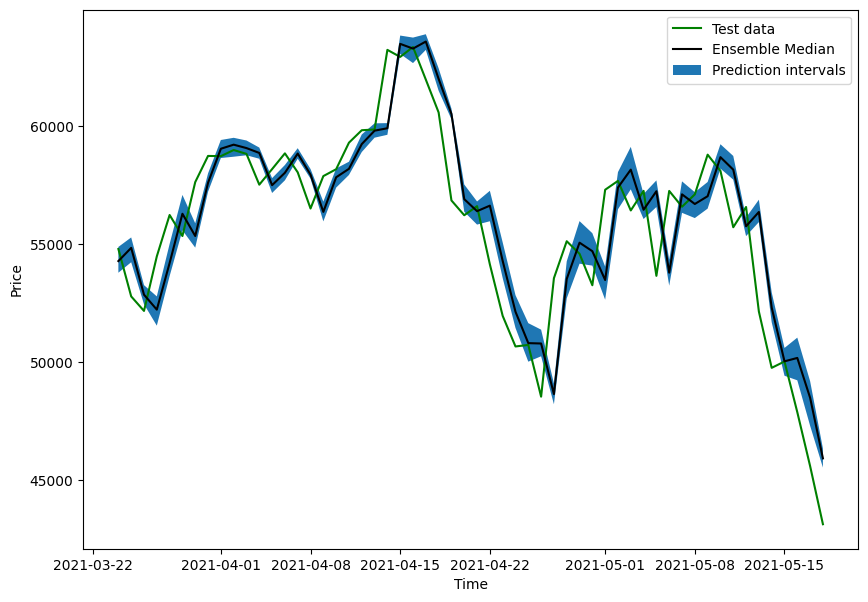

In [140]:
# Get the median/mean values of our ensemble preds

# Plot the median of ensemble predictions along with the prediction intervals
offset = 500
plt.figure(figsize= (10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], 'g-', label= 'Test data')
plt.plot(X_test.index[offset: ], ensemble_median[offset:], 'k-', label= 'Ensemble Median')
plt.xlabel("Time")
plt.ylabel("Price")
plt.fill_between(X_test.index[offset:], lower[offset:], upper[offset:], label= 'Prediction intervals')
plt.legend()


So far all of predictions have been lagging just like how naive model is lagging one timestep behind

## Aside: two types of uncertainity

Uncertanity estimates in machine learning seek out to qualitatively and quatitatively answer the questions:
1. What can my model know?
2. What does not my model know?

There are two major types of uncertainity in machine learning:
* **Aleatoric uncertainity** - this type of uncertainity cannot be reduced and it is often referred as data uncertainity or subway uncertainity
* **Epistemic uncertainity** - this type of uncertainity can be reduced, it is also referred to as model or coconut uncertainity

### Model 9: Create a model using all of our dataset and predict future

In the above models we have trained it using a pseudo future

Now, let's train the model using the historical data as a whole and then predict the future

In [142]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [144]:
# Train model on entire data to make predictions for the next day

X_all = bitcoin_prices_windowed.dropna().drop(['Price', 'block_reward'], axis= 1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()

len(X_all), len(y_all)


(2780, 2780)

In [146]:
features_data = tf.data.Dataset.from_tensor_slices(X_all)
labels_data = tf.data.Dataset.from_tensor_slices(y_all)
dataset_all = tf.data.Dataset.zip((features_data, labels_data)).batch(1024).prefetch(tf.data.AUTOTUNE)
dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [147]:
tf.random.set_seed(42)

# Create model
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation= 'relu'),
    layers.Dense(128, activation= 'relu'),
    layers.Dense(HORIZON_SIZE)
], name= 'model_9_Future')

model_9.compile(loss= 'mae',
                optimizer= tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs= 100,
            verbose= 1,
            callbacks= [create_model_checkpoint(model_9.name)])

Epoch 1/100
1/3 [=========>....................] - ETA: 1s - loss: 327.6149

3/3 [==============================] - 1s 7ms/step - loss: 3176.1848
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 124.6188

3/3 [==============================] - 0s 4ms/step - loss: 695.1363
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 48.0153

3/3 [==============================] - 0s 4ms/step - loss: 1792.0201
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 128.8629

3/3 [==============================] - 0s 5ms/step - loss: 1758.1136
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 90.0409

3/3 [==============================] - 0s 4ms/step - loss: 717.5405
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 22.5189

3/3 [==============================] - 0s 4ms/step - loss: 760.0546
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 59.0527

3/3 [==============================] - 0s 4ms/step - loss: 991.4268
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 51.8156

3/3 [==============================] - 0s 4ms/step - loss: 551.8654
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 21.0168

3/3 [==============================] - 0s 4ms/step - loss: 517.2678
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 43.8839

3/3 [==============================] - 0s 4ms/step - loss: 632.0566
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 36.4046

3/3 [==============================] - 0s 4ms/step - loss: 379.8723
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 20.9530

3/3 [==============================] - 0s 4ms/step - loss: 482.7538
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 28.0326

3/3 [==============================] - 0s 5ms/step - loss: 414.3302
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 19.9036

3/3 [==============================] - 0s 4ms/step - loss: 392.1734
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 28.6393

3/3 [==============================] - 0s 4ms/step - loss: 387.5047
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 20.9103

3/3 [==============================] - 0s 5ms/step - loss: 355.3289
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 20.2378

3/3 [==============================] - 0s 4ms/step - loss: 335.9553
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 18.0774

3/3 [==============================] - 0s 4ms/step - loss: 339.1136
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 21.5640

3/3 [==============================] - 0s 4ms/step - loss: 294.5483
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 17.0952

3/3 [==============================] - 0s 4ms/step - loss: 326.6310
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 16.8741

3/3 [==============================] - 0s 4ms/step - loss: 290.3738
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 18.4887

3/3 [==============================] - 0s 5ms/step - loss: 276.3869
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 16.2224

3/3 [==============================] - 0s 4ms/step - loss: 284.3169
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 16.0555

3/3 [==============================] - 0s 4ms/step - loss: 279.5974
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 16.7830

3/3 [==============================] - 0s 4ms/step - loss: 267.4825
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 15.7514

3/3 [==============================] - 0s 5ms/step - loss: 261.3237
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 15.9573

3/3 [==============================] - 0s 4ms/step - loss: 264.5322
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 15.5679

3/3 [==============================] - 0s 4ms/step - loss: 258.9029
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 15.1072

3/3 [==============================] - 0s 4ms/step - loss: 256.0488
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 15.0354

3/3 [==============================] - 0s 4ms/step - loss: 260.0728
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 14.9088

3/3 [==============================] - 0s 4ms/step - loss: 267.3281
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 15.0510

3/3 [==============================] - 0s 4ms/step - loss: 271.1881
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 14.7181

3/3 [==============================] - 0s 4ms/step - loss: 266.8988
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 15.1937

3/3 [==============================] - 0s 4ms/step - loss: 262.4242
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 14.6183

3/3 [==============================] - 0s 5ms/step - loss: 258.4226
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 15.0162

3/3 [==============================] - 0s 4ms/step - loss: 255.0548
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 14.5347

3/3 [==============================] - 0s 4ms/step - loss: 255.2871
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 14.8192

3/3 [==============================] - 0s 4ms/step - loss: 255.8628
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 14.4710

3/3 [==============================] - 0s 5ms/step - loss: 261.8232
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 14.6343

3/3 [==============================] - 0s 4ms/step - loss: 273.7692
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 14.4757

3/3 [==============================] - 0s 4ms/step - loss: 265.3269
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 14.8384

3/3 [==============================] - 0s 5ms/step - loss: 264.1112
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3985

3/3 [==============================] - 0s 4ms/step - loss: 258.4254
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 14.6771

3/3 [==============================] - 0s 4ms/step - loss: 259.5956
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3209

3/3 [==============================] - 0s 4ms/step - loss: 259.8963
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 14.5902

3/3 [==============================] - 0s 4ms/step - loss: 263.5564
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3197

3/3 [==============================] - 0s 4ms/step - loss: 257.6639
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 14.5964

3/3 [==============================] - 0s 4ms/step - loss: 257.9504
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2515

3/3 [==============================] - 0s 4ms/step - loss: 257.2833
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 14.4720

3/3 [==============================] - 0s 4ms/step - loss: 262.0459
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2505

3/3 [==============================] - 0s 4ms/step - loss: 256.8351
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 14.5015

3/3 [==============================] - 0s 4ms/step - loss: 257.7839
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1919

3/3 [==============================] - 0s 4ms/step - loss: 256.3528
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3907

3/3 [==============================] - 0s 5ms/step - loss: 262.4106
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1860

3/3 [==============================] - 0s 5ms/step - loss: 259.3418
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3793

3/3 [==============================] - 0s 4ms/step - loss: 266.4797
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2526

3/3 [==============================] - 0s 5ms/step - loss: 256.5963
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 14.4170

3/3 [==============================] - 0s 4ms/step - loss: 258.7195
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1064

3/3 [==============================] - 0s 4ms/step - loss: 258.6612
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3512

3/3 [==============================] - 0s 4ms/step - loss: 263.9070
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1671

3/3 [==============================] - 0s 4ms/step - loss: 257.0417
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3623

3/3 [==============================] - 0s 4ms/step - loss: 259.5622
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0882

3/3 [==============================] - 0s 5ms/step - loss: 257.2238
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3158

3/3 [==============================] - 0s 5ms/step - loss: 261.2851
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0964

3/3 [==============================] - 0s 5ms/step - loss: 255.6607
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2935

3/3 [==============================] - 0s 4ms/step - loss: 259.3557
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0674

3/3 [==============================] - 0s 5ms/step - loss: 254.9401
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2183

3/3 [==============================] - 0s 4ms/step - loss: 261.8872
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0181

3/3 [==============================] - 0s 4ms/step - loss: 261.6365
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3243

3/3 [==============================] - 0s 4ms/step - loss: 262.9024
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1045

3/3 [==============================] - 0s 4ms/step - loss: 253.2058
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2336

3/3 [==============================] - 0s 5ms/step - loss: 255.9132
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9559

3/3 [==============================] - 0s 5ms/step - loss: 257.0657
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2265

3/3 [==============================] - 0s 4ms/step - loss: 259.7841
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9899

3/3 [==============================] - 0s 5ms/step - loss: 255.5194
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2610

3/3 [==============================] - 0s 4ms/step - loss: 255.1327
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9275

3/3 [==============================] - 0s 4ms/step - loss: 255.1048
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2092

3/3 [==============================] - 0s 4ms/step - loss: 256.2174
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9353

3/3 [==============================] - 0s 4ms/step - loss: 253.7271
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1771

3/3 [==============================] - 0s 4ms/step - loss: 255.1667
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 13.8964

3/3 [==============================] - 0s 4ms/step - loss: 254.6855
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1497

3/3 [==============================] - 0s 4ms/step - loss: 257.0565
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 13.8853

3/3 [==============================] - 0s 4ms/step - loss: 256.9577
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2283

3/3 [==============================] - 0s 4ms/step - loss: 255.0568
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9164

3/3 [==============================] - 0s 4ms/step - loss: 248.8242
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1588

3/3 [==============================] - 0s 4ms/step - loss: 246.9415
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 13.8025

3/3 [==============================] - 0s 4ms/step - loss: 248.4271
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0319

3/3 [==============================] - 0s 4ms/step - loss: 252.5223
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 13.8178

3/3 [==============================] - 0s 4ms/step - loss: 252.6893
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0695

3/3 [==============================] - 0s 4ms/step - loss: 255.1747
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 13.8140

3/3 [==============================] - 0s 4ms/step - loss: 254.2705
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1696

3/3 [==============================] - 0s 4ms/step - loss: 250.8552
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 13.8132

3/3 [==============================] - 0s 4ms/step - loss: 245.8503
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0299

3/3 [==============================] - 0s 4ms/step - loss: 246.3570
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 13.7384

3/3 [==============================] - 0s 4ms/step - loss: 247.7982
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9197

3/3 [==============================] - 0s 4ms/step - loss: 255.0939
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 13.7385

3/3 [==============================] - 0s 4ms/step - loss: 257.3351
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1672

3/3 [==============================] - 0s 4ms/step - loss: 252.6680
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 13.7780

3/3 [==============================] - 0s 4ms/step - loss: 247.5989
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9708

3/3 [==============================] - 0s 4ms/step - loss: 249.7365


#### Make predictions into the future

In [148]:
# How many timesteps to predict into the future
INTO_FUTURE = 14

To make predictions into the future we want a function which:

1. Takes as input:
  * a list of values
  * a trained model
  * a window into the future to predict
  * the window size a model was trained
2. Create an empty list for future forecasts to update
3. Loop `INTO_FUTURE` times making a predictionon `WINDOW_SIZE` sequences which update to remove the first value and append the lates prediction

In [158]:
bitcoin_prices_windowed.dropna().drop(columns= ['Price', 'block_reward']).iloc[-WINDOW_SIZE:, :].to_numpy()

array([[55715.54665129, 58102.19142623, 58788.20967893, 57107.12067189,
        56583.84987917, 57252.7021845 , 53658.84312082],
       [56573.5554719 , 55715.54665129, 58102.19142623, 58788.20967893,
        57107.12067189, 56583.84987917, 57252.7021845 ],
       [52147.82118698, 56573.5554719 , 55715.54665129, 58102.19142623,
        58788.20967893, 57107.12067189, 56583.84987917],
       [49764.1320816 , 52147.82118698, 56573.5554719 , 55715.54665129,
        58102.19142623, 58788.20967893, 57107.12067189],
       [50032.69313676, 49764.1320816 , 52147.82118698, 56573.5554719 ,
        55715.54665129, 58102.19142623, 58788.20967893],
       [47885.62525472, 50032.69313676, 49764.1320816 , 52147.82118698,
        56573.5554719 , 55715.54665129, 58102.19142623],
       [45604.61575361, 47885.62525472, 50032.69313676, 49764.1320816 ,
        52147.82118698, 56573.5554719 , 55715.54665129]])

In [167]:
def future_predictions(values,
                       model,
                       into_future,
                       window_size= WINDOW_SIZE):
  '''
  Make future forecasts into future steps after value ends

  Return future forecasts as a list of floats
  '''

  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make into future number of predictions, altering the data which gets predicted on each
  for _ in range(into_future):
    # Retrain the model before predicting with the new window

    # Predict on the last window and update it for the next prediction
    future_pred = model.predict(tf.expand_dims(last_window, axis= 0))

    print(f'Predicting on: {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}')
    print('\n')

    # Append predictions to the future forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update the last window with new pred and get WINDOW_SIZE most recent last winodw
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE: ]

  return future_forecast


In [168]:
future_forecast = future_predictions(values= y_all,
                                     model= model_9,
                                     into_future= INTO_FUTURE,
                                     window_size= WINDOW_SIZE)

1/1 [==============================] - 0s 19ms/step
Predicting on: [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55544.1015625


1/1 [==============================] - 0s 18ms/step
Predicting on: [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55544.1015625 ] -> Prediction: 51137.26953125


1/1 [==============================] - 0s 17ms/step
Predicting on: [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55544.1015625  51137.26953125] -> Prediction: 47710.0390625


1/1 [==============================] - 0s 17ms/step
Predicting on: [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55544.1015625  51137.26953125 47710.0390625 ] -> Prediction: 49228.7109375


1/1 [==============================] - 0s 18ms/step
Predicting on: [47885.62525472 45604.61575361 43144.47129086 55544.1015625
 51137.26953125 47710.0390625  49228.7109375 ] -

In [169]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


### Plt future forecast

In [181]:
def get_future_date(start_date, into_future, offset= 1):
  '''
  Return array of datetime values ranging form start_date to start_date + into_future
  '''

  start_date = start_date + np.timedelta64(offset, 'D')
  end_date = start_date + np.timedelta64(into_future, 'D')

  return np.arange(start_date, end_date, dtype= 'datetime64[D]')

In [173]:
# Last timestep of timstep of timesteps
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [176]:
type(last_timestep)

pandas._libs.tslibs.timestamps.Timestamp

In [182]:
# Get next two weeks
next_time_steps = get_future_date(start_date= last_timestep,
                                   into_future= INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [185]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55544.1  , 51137.27 , 47710.04 , 49228.71 , 45950.63 ,
        46954.76 , 47385.71 , 53496.664, 49760.074, 46510.887, 48482.473,
        46184.98 , 48162.504, 49291.59 ], dtype=float32))

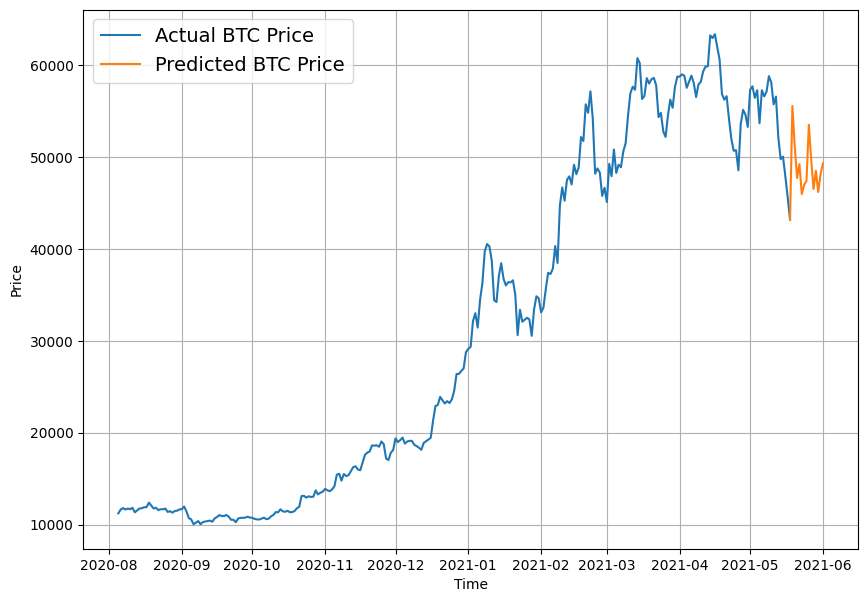

In [186]:
# Plot future prices predictions of Bitcoin
plt.figure(figsize= (10, 7))
plot_time_series(bitcoin_prices.index, bitcoin_prices['Price'], start= 2500, format= '-', label= 'Actual BTC Price')
plot_time_series(next_time_steps, future_forecast, format='-', label= 'Predicted BTC Price')
